In [9]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
from scipy import sparse 
%matplotlib inline

from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.ensemble import RandomForestClassifier,AdaBoostClassifier
from sklearn.tree import DecisionTreeRegressor,DecisionTreeClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC,NuSVC,SVR,NuSVR
from sklearn.model_selection import GridSearchCV
from sklearn import metrics
from sklearn import neighbors

In [10]:
# Function to load csr matrix of samples and list of colnames from file
def load_sparse_csr_from_csv(filename):
    indices = np.loadtxt(filename+"_indices.csv",unpack=True,delimiter=",")
    indptr = np.loadtxt(filename+"_indptr.csv",unpack=True,delimiter=",")
    shape = np.loadtxt(filename+"_shape.csv",unpack=True,delimiter=",")
    col_names = np.loadtxt(filename+"_col_names.csv",unpack=True,delimiter=",",dtype=str)
    data = np.ones_like(indices,dtype=np.int8)
    
    return sparse.csr_matrix((data, indices, indptr),
                         shape = shape),col_names

In [41]:
# load the target values of brightness and create a binary vector 
# with 1 for samples with brightness above threshold and 0 otherwise
y,std = np.loadtxt("target_values.csv",unpack=True,delimiter=",")
y_bin = np.where(y >= y[0]*0.95,1.,0.)
print y.shape
print y_bin.sum(),y_bin.shape

(54025,)
18396.0 (54025,)


In [42]:
# Load the sparse matrix and column names from file
X,col_names = load_sparse_csr_from_csv("sparse_csr")
print X.shape

(54025, 1879)


In [43]:
# Retrieve all the mutants with single mutations 
# and create the look up table for this single mutations
single_mutations = {}
for i in xrange(X.shape[0]):
    if X.getrow(i).indices.shape[0] == 1:
        index = X.getrow(i).indices[0]
        mutation = col_names[index]
        #print mutation,i
        if mutation not in single_mutations:
            single_mutations[mutation] = {"id":index,"mutants":[i]}
        else:
            single_mutations[mutation]["mutants"].append(i)

In [44]:
# run the classifier using stratified shuffle split cross-validation and record average accuracy
kf = KFold(n_splits = 5,shuffle = True)
cv = StratifiedShuffleSplit(n_splits=5, test_size=0.1)
yhat = np.zeros((X.shape[0],1))
acc = np.zeros((5,1))

i = 0
for train_idx, test_idx in cv.split(X,y_bin):
    #print y_bin[train_idx].shape,y_bin[train_idx].sum()
    X_train = X[train_idx,:]
    X_test = X[test_idx,:]
    
    #clf = DecisionTreeClassifier(max_depth = 5,min_samples_split = 100)
    #clf = DecisionTreeClassifier()
    clf = RandomForestClassifier(min_samples_split=20)
    #clf = LogisticRegression()
    #clf = NuSVC()
    
    yhat_train = clf.fit(X_train,y_bin[train_idx]).predict(X_train)
    yhat[test_idx] = clf.predict(X_test).reshape(-1,1)   
    
    acc[i,:] = metrics.accuracy_score(y_bin[test_idx],yhat[test_idx])
    i += 1
    print 'Training Accuracy score: ' + str(metrics.accuracy_score(y_bin[train_idx],yhat_train))
    print 'Testing Accuracy score: ' + str(metrics.accuracy_score(y_bin[test_idx],yhat[test_idx]))
    
#print '\nAccuracy score: ' + str(metrics.accuracy_score(y_bin,yhat))
print '\nAverage accuracy score: ' + str(acc.mean())
print metrics.classification_report(y_bin,yhat)

Training Accuracy score: 0.951832503805
Testing Accuracy score: 0.849157875254
Training Accuracy score: 0.950906996833
Testing Accuracy score: 0.858226910975
Training Accuracy score: 0.952655176669
Testing Accuracy score: 0.849528039978
Training Accuracy score: 0.951359466908
Testing Accuracy score: 0.850453451786
Training Accuracy score: 0.951277199622
Testing Accuracy score: 0.857856746252

Average accuracy score: 0.853044604849
             precision    recall  f1-score   support

        0.0       0.73      0.95      0.83     35629
        1.0       0.77      0.34      0.47     18396

avg / total       0.75      0.74      0.70     54025



In [45]:
# train the classifer using full data set
clf = RandomForestClassifier(min_samples_split=20)
clf.fit(X,y_bin)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=20, min_weight_fraction_leaf=0.0,
            n_estimators=10, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False)

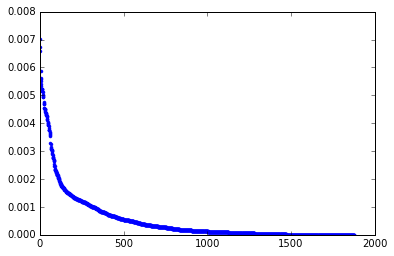

In [46]:
# predict the category for all possible single mutations available in the dataset
pos_mutations = {}
neg_mutations = {}
count = 0
for i in clf.feature_importances_.argsort()[::-1]:
    if col_names[i] not in single_mutations:
        occurence = X[:,i].sum()
        #med_brigtness = np.median(y[X[:,i]>0])
        mutation_vector = np.zeros((1,X.shape[1]))
        mutation_vector[0,i] = 1
        h = clf.predict_proba(mutation_vector)
        if h[0][1] > 0.9:
            pos_mutations[col_names[i]] = (h[0][1],occurence,count)
            #print count,col_names[i],clf.feature_importances_[i]
            #print h
    else:
        occurence = X[:,i].sum()
        #med_brigtness = np.median(y[X[:,i]>0])
        mutation_vector = np.zeros((1,X.shape[1]))
        mutation_vector[0,i] = 1
        h = clf.predict_proba(mutation_vector)
        if h[0][0] > 0.9:
            neg_mutations[col_names[i]] = (h[0][1],occurence,count)
    count += 1
    
    
plt.plot(np.sort(clf.feature_importances_)[::-1],".")


In [47]:
# print all the identified positive mutations with confidence level of the classifier, 
# number of times it occured in the dataset, and its importance as feature for the classifier  
print len(pos_mutations)
for mutation in pos_mutations:
    print mutation, pos_mutations[mutation]

489
SK50L (1.0, 2, 1582)
SK50D (1.0, 1, 1798)
SD101H (1.0, 2, 1689)
SK50A (1.0, 1, 1822)
SD101S (1.0, 1, 1645)
SD80E (1.0, 10, 1506)
SK50V (1.0, 2, 1800)
SS26* (1.0, 1, 1694)
SL139* (1.0, 1, 1560)
SK207M (1.0, 2, 1516)
SK43V (1.0, 2, 1779)
SK43W (1.0, 1, 1757)
SK43N (1.0, 7, 1648)
SK207V (1.0, 4, 1591)
SN210F (1.0, 1, 1721)
SN210G (1.0, 8, 1279)
SN210H (1.0, 79, 637)
SG158A (1.0, 20, 1186)
SN210R (1.0, 2, 1519)
SN210V (1.0, 1, 1654)
SD171S (1.0, 2, 1643)
SP11T (1.0, 15, 1525)
SS26V (1.0, 1, 1686)
SE30M (1.0, 1, 1590)
SI12Y (1.0, 1, 1791)
SI12D (1.0, 1, 1523)
SI12A (1.0, 2, 1782)
SE30R (1.0, 2, 1663)
SE30Q (1.0, 2, 1575)
SN144A (1.0, 2, 1842)
SD80K (1.0, 1, 1705)
SS145Y (1.0, 1, 1453)
SS145T (1.0, 17, 1489)
SN119* (1.0, 1, 1845)
SF69D (1.0, 1, 1868)
SS145D (1.0, 1, 1714)
SS145A (1.0, 3, 1512)
SF98R (1.0, 1, 1835)
SN119R (1.0, 1, 1870)
SN119L (1.0, 1, 1833)
SI169A (1.0, 3, 1383)
SI169M (1.0, 12, 1352)
SL42S (1.0, 1, 1524)
SG18R (1.0, 4, 1425)
SN119A (1.0, 1, 1708)
SN119C (1.0, 1, 1788)
S

In [48]:
neg_mutations["SW55R"]

(0.0, 589, 0)

In [49]:
# print all the identified negative mutations with confidence level of the classifier, 
# number of times it occured in the dataset, and its importance as feature for the classifier 
len(neg_mutations)
for mutation in neg_mutations:
    print mutation, neg_mutations[mutation]

SE30* (0.0, 23, 564)
SN119I (0.0092592592592592587, 126, 170)
SH215L (0.0, 135, 159)
SD80V (0.0, 127, 209)
SQ182P (0.0, 32, 787)
SD101N (0.088699055330634283, 88, 375)
SK124* (0.034851851851851849, 143, 103)
SP56H (0.0, 13, 658)
SH215R (0.0, 367, 35)
SH197Y (0.0, 52, 486)
SN183Y (0.0060606060606060606, 106, 281)
SY72C (0.0, 271, 71)
SY72F (0.045225931475931479, 122, 193)
SM216T (0.033508158508158511, 297, 73)
SY104C (0.099778703686838319, 253, 102)
SV59E (0.0, 175, 101)
SY104H (0.0043478260869565218, 214, 96)
SL13P (0.0, 313, 54)
SK43E (0.012454212454212455, 371, 50)
SQ67R (0.0, 422, 21)
SH167R (0.0, 437, 7)
SH167P (0.0, 48, 422)
SP11L (0.0, 41, 742)
SL40P (0.0, 369, 40)
SL40Q (0.0, 153, 97)
SP11A (0.0, 19, 604)
SW55* (0.0, 86, 344)
SK156* (0.076307026307026307, 148, 113)
SD100V (0.046572393822393823, 121, 231)
SL16R (0.0, 42, 571)
SG33D (0.0, 39, 719)
SL205R (0.0, 47, 518)
SP11S (0.0, 55, 387)
SP56L (0.095123385386543274, 60, 447)
SQ67L (0.0, 142, 116)
SI12T (0.01111111111111111, 375,

In [56]:
# checking the prediction of classifier on provided set of mutants with single mutations
count = 0
for mutation in single_mutations:
    index = single_mutations[mutation]["id"]
    mutation_vector = np.zeros((1,X.shape[1]))
    mutation_vector[0,index] = 1
    yhat = clf.predict(mutation_vector)
    h = clf.predict_proba(mutation_vector)
    for mutant in single_mutations[mutation]["mutants"]:
        if yhat == y_bin[mutant]:
            count += 1
        else:
            print yhat[0],y_bin[mutant],h[0][int(yhat[0])],y[mutant]/y[0]
print count*1./len(single_mutations.keys())

0.0 1.0 0.851541274817 0.953500877875
1.0 0.0 0.867857142857 0.939879705636
0.0 1.0 0.638449014753 0.966449864353
0.0 1.0 0.59398150656 0.95235547334
0.0 1.0 0.568118682084 0.959152615744
0.0 1.0 0.583650793651 0.966745626087
0.0 1.0 0.728497150997 0.951645645177
0.0 1.0 0.833621931783 0.957216720755
0.0 1.0 0.797356561567 0.963817584917
0.0 1.0 0.695441253829 0.951487009338
0.0 1.0 0.537820512821 0.987018748605
0.0 1.0 0.736766640129 0.969407481696
0.0 1.0 0.723067096487 0.952742652337
0.0 1.0 0.727571363502 0.977169882851
1.0 0.0 0.6 0.34981353567
0.0 1.0 0.544047619048 0.953242758543
0.0 1.0 0.785104937133 0.961591305681
1.0 0.0 0.556666666667 0.913016473929
0.0 1.0 0.641833836099 0.968528262722
0.0 1.0 0.680361477991 0.956143912282
0.0 1.0 0.798329380764 0.962233915267
1.0 0.0 0.758055555556 0.947432384834
0.0 1.0 0.562764281067 0.968678832333
1.0 0.0 0.65 0.945017893585
1.0 0.0 0.6 0.406252940813
0.0 1.0 0.721182771477 0.959789847844
0.0 1.0 0.73804154849 0.970983085118
0.0 1.0 0.

In [ ]:
kf = KFold(n_splits = 4,shuffle = True)
yhat = np.zeros((X.shape[0],1))

for train_idx, test_idx in kf.split(X,y):
    X_train = X[train_idx,:]
    X_test = X[test_idx,:]
    
    #clf = DecisionTreeClassifier(max_depth = 5,min_samples_split = 100)
    #clf = LogisticRegression()
    clf = NuSVR()
    
    print "Training..."
    yhat_train = clf.fit(X_train,y[train_idx]).predict(X_train)
    print "Predicting..."
    yhat[test_idx] = clf.predict(X_test).reshape(-1,1)   
    
    print 'Training Accuracy score: ' + str(metrics.mean_squared_error(y[train_idx],yhat_train))
    print 'Testing Accuracy score: ' + str(metrics.mean_squared_error(y[test_idx],yhat[test_idx]))
    
print '\nAccuracy score: ' + str(metrics.mean_squared_error(y,yhat))
print metrics.classification_report(y,yhat)